<span style="font-size:250%">Access the database</span>

This notebook is used for exploring, analyzing, and aggragating the GHTorrent Dataset.<br>
It primarily includes the queries with which I created my materialized views and some of the queries with which I explored the dataset.

From the work in this notebook, the small [dbUtils.py](./dbUtils.py) module was created.

---

In [1]:
import numpy as numpy
import matplotlib.pyplot as pyplot

In [2]:
%load_ext autoreload
%aimport dbUtils
%autoreload 1

# Exploring basic GHTorrent Tables
In the beginning, I tried to explore which data is available and how it is composed

* 1.368.235.072 Commits
*    32.411.734 Users
*   125.486.232 Projects

In [4]:
dbUtils.runQuery('''
    SELECT COUNT(*) FROM ght.commits
''')

Time used: 2832.7056472301483


,count
0,1368235072


In [7]:
dbUtils.runQuery('''
    SELECT * 
    FROM ght.commits
    LIMIT 10
''')

Time used: 0.7459335327148438


,id,sha,author_id,committer_id,project_id,created_at
0,659097136,71c562ee7229025a7b0100f2f6777ddd38787e46,34908882,34908882,60593534,2017-03-31 03:23:47
1,659097137,602eeca0f6cf3c757632466a31d2767572cf3107,30554679,30351173,58045027,2017-03-31 03:23:57
2,659097138,346c39b02dcf1a5036c133d042e1ecc479fa7776,4752971,4752971,60810981,2017-03-31 03:23:56
3,659097139,0c2721961165a87a16b8d21dcffc803945bdc39e,34002213,34002213,56875827,2017-03-31 03:23:30
4,659097140,0bd4336b30c35ada38e620f103edaadd72a5a86b,780889,780889,19453540,2017-03-31 03:23:56
5,659097141,93beb5abb9f2699cda3a68b422621dcf64759497,32094706,32094706,60236433,2017-03-31 03:23:58
6,659097142,f2c7176cbaf54fcffe473a3b95e78146098dac4d,7040125,7040125,59349380,2017-03-31 03:22:07
7,659097143,20fccf688358c14db512f16d1ff6c947c6ee402c,11249739,11249739,38434455,2017-03-31 03:23:33
8,659097144,8158f6bfb4958abdc145ca420fa3712622d40f40,10550932,10550932,52984520,2017-03-31 03:23:46
9,659097145,fa45b10200be9f6cc0a008dce17b145c6dbb6ec3,7198145,30351173,55832557,2017-03-31 03:24:01


In [5]:
dbUtils.runQuery('''
    SELECT * FROM ght.users
''')

Time used: 674.6072964668274


,id,login,company,created_at,type,fake,deleted,long,lat,country_code,state,city,location
0,40898094,allydunham,None,2017-07-24 17:04:33,USR,False,False,0.000000,0.000000,None,None,None,None
1,40898095,Hamzehsh2,None,2018-01-26 10:38:47,USR,False,False,0.000000,0.000000,None,None,None,None
2,40898096,tkzjustin,Eternal Dragonz,2017-01-21 03:36:04,USR,False,False,151.203003,-33.874001,au,NSW,Sydney,"Sydney, AU"
3,40898097,zimj,#currentlyastudent,2017-06-18 09:48:36,USR,False,False,72.830093,18.930130,in,Maharashtra,Mumbai,Mumbai
4,40898098,NHAUROSH,None,2018-01-26 10:45:42,USR,True,False,NaN,NaN,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32411729,40898090,EWPYLDIP,None,2018-01-26 10:45:12,USR,True,False,NaN,NaN,None,None,None,None
32411730,40898091,TCPPCJXA,None,2018-01-26 10:45:13,USR,True,False,NaN,NaN,None,None,None,None
32411731,40898092,WilonaDU,None,2018-01-26 02:59:47,USR,False,False,0.000000,0.000000,None,None,None,None
32411732,40898093,ttrgrchck,None,2018-01-26 10:42:56,USR,False,False,0.000000,0.000000,None,None,None,None


In [7]:
dbUtils.runQuery('''
    SELECT * FROM ght.projects
''')

Time used: 2348.3794589042664


,id,url,owner_id,name,description,language,created_at,forked_from,deleted,updated_at,forked_commit_id
0,11689147,https://api.github.com/repos/robot9706/Minecra...,2852592,MinecraftModelExporter,A simple tool for converting Minecraft worlds ...,C#,2014-08-26 17:16:07,NaN,False,2016-03-03 00:03:18,NaN
1,11689151,https://api.github.com/repos/Gruuler/pinteresting,4856900,pinteresting,,Ruby,2014-08-25 21:26:22,NaN,False,2016-02-18 03:44:57,NaN
2,11689152,https://api.github.com/repos/infolaverage/symf...,3332197,symfony1,"Fork of symfony 1.4 with DIC, form enhancement...",PHP,2014-08-26 14:49:52,265030.0,False,2016-02-20 10:10:52,NaN
3,11689155,https://api.github.com/repos/zccoin/skycoinwhi...,2304600,skycoinwhitepapers,SkyCoin whitepapers zh_cn translation,None,2014-08-25 17:49:12,9480992.0,False,2016-03-07 03:55:34,NaN
4,11689158,https://api.github.com/repos/abursavich/kubern...,654627,kubernetes,Container Cluster Manager,Go,2014-09-15 19:05:36,22091370.0,False,2016-02-04 00:09:43,NaN
...,...,...,...,...,...,...,...,...,...,...,...
125486227,11689141,https://api.github.com/repos/strannik-06/recycle,5066285,recycle,,PHP,2014-08-29 08:50:53,NaN,False,2016-03-04 13:53:29,NaN
125486228,11689142,https://api.github.com/repos/maxmode/recycle-1,2545797,recycle-1,,PHP,2014-09-02 10:43:03,11689141.0,False,2016-02-27 14:54:11,NaN
125486229,11689144,https://api.github.com/repos/chris-gibson/Angu...,598044,AngularExamples,A place to store angular examples,JavaScript,2014-08-26 17:15:01,NaN,False,2016-02-10 15:43:03,NaN
125486230,11689145,https://api.github.com/repos/jstclair/editable...,234061,editableCell,A component for turning table cells into selec...,JavaScript,2014-05-23 13:24:15,4040064.0,False,2016-02-23 11:07:24,NaN


In [2]:
dbUtils.runQuery('''
    select column_name, data_type from information_schema.columns
    where table_name = 'commits';
''')

Time used: 0.3947935104370117


,column_name,data_type
0,id,integer
1,author_id,integer
2,committer_id,integer
3,project_id,integer
4,created_at,timestamp without time zone
5,sha,character varying


___

### Update all views

Don't call this anymore! //TODO

In [5]:
dbUtils.runQuery('''
    SELECT matviewname::TEXT AS name
    FROM pg_matviews
    WHERE schemaname = 'crm20'
    AND matviewname::TEXT LIKE 'lb%%'
''')

Time used: 0.004951953887939453


,name
0,lb_sample_projects


In [ ]:
matViews = dbUtils.runQuery('''
    SELECT matviewname::TEXT AS name
    FROM pg_matviews
    WHERE schemaname = 'crm20'
    AND matviewname::TEXT LIKE 'lb%%'
''')['name']
for matView in matViews:
    print('Updating matView '+matView)
    dbUtils.runQuery('''
        REFRESH MATERIALIZED VIEW crm20.{name}; 
        SELECT count(*) FROM crm20.{name}
    '''.format(name=matView))

Time used: 0.05512547492980957


Updating matView lb_sample_commits_all
Time used: 1876.2644941806793


Updating matView lb_sample_commits
Time used: 14170.458399534225


Updating matView lb_sample_projects
Time used: 3.5932347774505615


Updating matView lb_languages
Time used: 0.46927762031555176


Updating matView lb_polyglots
Time used: 0.021283864974975586


Updating matView lb_changes


# Creating the basis for determining the users for my experiment 

As the aim of this project is to analyze the code of special groups of developers, developer data needs to be aggregated. Especially language loc of developers is interesting.

## Get sample users: 
The basis for all further aggregation is the `lb_sample_users` table. It contains a subset of all users in order to reduce the massive dataset that GHTorrent provides. Future work could abolish this limitation and run this project on all known users. Currently we just take 10 of 113 users, so approx. every 11th user. These are approx. 2.8M.

In [3]:
sampleUsers = dbUtils.runQuery('''
    DELETE FROM crm20.lb_sample_users;
    
    INSERT INTO crm20.lb_sample_users
        SELECT id 
        FROM ght.users 
        WHERE MOD(id, 113) = ANY('{1,2,3,5,8,13,21,34,55,89}')
        AND type = 'USR';
    
    SELECT * FROM crm20.lb_sample_users
''')
display(sampleUsers)

Time used: 31.120256185531616


,id
0,40898095
1,40898098
2,40898103
3,40898111
4,40898124
...,...
2754873,40898032
2754874,40898066
2754875,40898091
2754876,40898092


## Get projects the sample users worked on:
The `lb_sample_projects` materialized view is an intermediate view used to quickly determine the commits of the sample developers (which in turn are used to reflect on the coding activity of the developers). This detour is needed because of the massive size of the `ght.commits` table. Approx 973k entries.

In [4]:
dbUtils.runQuery('''
    DROP MATERIALIZED VIEW IF EXISTS crm20.lb_sample_projects CASCADE;
    
    CREATE MATERIALIZED VIEW crm20.lb_sample_projects AS (
        SELECT DISTINCT repo_id
        FROM lb_sample_users, ght.project_members 
        WHERE id = user_id
    );
    
    SELECT * FROM crm20.lb_sample_projects
''')

Time used: 20.05700969696045


,repo_id
0,1
1,3
2,27
3,34
4,37
...,...
973402,137608196
973403,137608332
973404,137608999
973405,137609212


## Get Commits of Sample Users:

The materialized view `lb_sample_commits` includes all known commits that have been done by the sample users. These can later be used to reflect on the coding behavior of the user, as we can see which code a user wrote. Approx 15M entries.

In [9]:
dbUtils.runQuery('''
    DROP MATERIALIZED VIEW IF EXISTS crm20.lb_sample_commits;
    
    CREATE MATERIALIZED VIEW crm20.lb_sample_commits AS (
        SELECT commits.id, sha, author_id, created_at, project_id 
        FROM crm20.lb_sample_projects, ght.commits, lb_sample_users
        WHERE repo_id = project_id
        AND author_id = lb_sample_users.id
    );
    
    SELECT * FROM crm20.lb_sample_commits
''')

Time used: 4282.222692966461


,id,sha,author_id,created_at,project_id
0,659298170,dfeaab04133a6a6673627aca05a226c72a456913,33618859,2017-03-31 10:09:59,60749223
1,660034020,0d0f26ccd423b850592ac243380bdb7dec8a8380,34104422,2017-04-01 11:43:16,59166975
2,660034029,301f441887b5a466cab17337502be81fabafa5d4,34104422,2017-04-01 11:43:51,59166975
3,660473226,08f03d40609d4e462802c4708ec1f3b1e1e65a65,34275391,2017-04-02 06:03:02,57899338
4,660473786,5db30f2999d9746245ca24cc3eec5d07de86e59c,34275391,2017-04-02 06:04:50,57899338
...,...,...,...,...,...
14989019,658761037,19bc50fe73e4b0c02a6783dcdf89e91415d89c50,1544938,2017-03-30 17:32:57,15785976
14989020,658843584,589305637a8c77decb2401394cd0949f9bc72bcb,1544938,2017-03-30 17:08:17,15785976
14989021,658843597,794e0b908e2de2d833f7c83467209d5ff8a4db83,1544938,2017-03-30 19:31:17,15785976
14989022,658920360,85901f6275239b677047e285b2670bddde4d0756,54920,2017-02-23 16:51:12,15754


## Question: How does ght.raw_patches count deletions and changes?

The `ght.raw_patches` provides information about commit changes (and therefore languages). <br>
However, I need to know how the table calculates its numbers for changed loc. This was especially important in the first big iteration, as at that time I used this information to calculate commit sizes for the metrics. However, the data is still used to determine how many loc in which language a developer has approximately written.

For starters I took a random commit from https://github.com/italiangrid/voms-admin-server (which is a repo I can still access on github to cross reference what how the numbers are calculated)

In [131]:
dbUtils.runQuery('''
    SELECT *
    FROM ght.raw_patches
    WHERE sha = '95b5c803ccfc8ae3c015a4681ec14f5b2579896a'
    LIMIT 20
''', True)

,sha,name,previous_filename,changes,deletions,status,patch
0,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/java/org/glite/secu...,,29,13,modified,"@@ -17,12 +17,16 @@\n \n import java.util.List..."
1,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/java/org/glite/secu...,,43,7,modified,"@@ -24,8 +24,11 @@\n import org.hibernate.Crit..."
2,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/java/org/glite/secu...,,33,0,added,"@@ -0,0 +1,33 @@\n+/**\n+ * Copyright (c) Isti..."
3,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/java/org/glite/secu...,,17,4,modified,"@@ -21,6 +21,7 @@\n import org.glite.security...."
4,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/java/org/glite/secu...,,7,1,modified,"@@ -99,10 +99,13 @@ public void checkOrgDBConn..."
5,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/java/org/glite/secu...,,46,34,modified,"@@ -63,41 +63,14 @@ protected void synchronize..."
6,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/webapp/jquery-ui/jq...,,16617,0,added,
7,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/webapp/jquery-ui/jq...,,1225,0,added,"@@ -0,0 +1,1225 @@\n+/*! jQuery UI - v1.11.4 -..."
8,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/webapp/jquery-ui/im...,,0,0,added,
9,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/webapp/jquery-ui/im...,,0,0,added,


To find the repository online: What is it's project id?

In [129]:
dbUtils.runQuery('''
    SELECT * 
    FROM ght.commits
    WHERE sha='95b5c803ccfc8ae3c015a4681ec14f5b2579896a'
''', True)

,id,sha,author_id,committer_id,project_id,created_at
0,650784538,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,119958,30351173,1586836,2017-03-23 19:55:24


What is the url for this project id?

In [130]:
dbUtils.runQuery('''
    SELECT * 
    FROM ght.projects
    WHERE id='1586836'
''', True)['url'][0]

'https://api.github.com/repos/italiangrid/voms-admin-server'

See https://github.com/italiangrid/voms-admin-server/commit/95b5c803ccfc8ae3c015a4681ec14f5b2579896a: 

By looking the commit up online I found out the following:<br>
* For Docker-compose: Changes = Additions + Deletions, but: Changed lines have additions and deletes so count "twice"
* configure-vo.sh was completely deleted, so changes = deletions

I also tried out the idea to derive all analysis infos directly from the attached patches in the table, but later discarded this idea. However, it basically works to extract changed lines using psql regex.

In [246]:
dbUtils.runQuery('''
    SELECT name, patch, (SELECT COUNT(*) FROM REGEXP_MATCHES(patch, '^\+', 'gn')) as occ
    FROM ght.raw_patches
    WHERE sha = '95b5c803ccfc8ae3c015a4681ec14f5b2579896a'
    LIMIT 20
''', True)

,name,patch,occ
0,voms-admin-server/src/main/java/org/glite/secu...,"@@ -17,12 +17,16 @@\n \n import java.util.List...",16
1,voms-admin-server/src/main/java/org/glite/secu...,"@@ -24,8 +24,11 @@\n import org.hibernate.Crit...",36
2,voms-admin-server/src/main/java/org/glite/secu...,"@@ -0,0 +1,33 @@\n+/**\n+ * Copyright (c) Isti...",33
3,voms-admin-server/src/main/java/org/glite/secu...,"@@ -21,6 +21,7 @@\n import org.glite.security....",13
4,voms-admin-server/src/main/java/org/glite/secu...,"@@ -99,10 +99,13 @@ public void checkOrgDBConn...",6
5,voms-admin-server/src/main/java/org/glite/secu...,"@@ -63,41 +63,14 @@ protected void synchronize...",12
6,voms-admin-server/src/main/webapp/jquery-ui/jq...,,0
7,voms-admin-server/src/main/webapp/jquery-ui/jq...,"@@ -0,0 +1,1225 @@\n+/*! jQuery UI - v1.11.4 -...",1225
8,voms-admin-server/src/main/webapp/jquery-ui/im...,,0
9,voms-admin-server/src/main/webapp/jquery-ui/im...,,0


## Commit Data with languages (file endings) and loc

In [ ]:
dbUtils.runQuery('''
    DROP MATERIALIZED VIEW IF EXISTS crm20.lb_changes CASCADE;
    CREATE MATERIALIZED VIEW crm20.lb_changes AS
        (SELECT commit_id, lb_sample_commits.sha, SUM(changes-deletions) AS loc, SUBSTRING(name from '\.([^\.]*)$') AS language
        FROM crm20.lb_sample_commits, ght.raw_patches
        WHERE lb_sample_commits.sha = raw_patches.sha
        GROUP BY commit_id, lb_sample_commits.sha, language);
    SELECT * FROM crm20.lb_changes
''')

Simple table to get extended commit data:

In [200]:
dbUtils.runQuery('''
    DROP MATERIALIZED VIEW IF EXISTS crm20.lb_java_commits CASCADE;
    CREATE MATERIALIZED VIEW crm20.lb_java_commits AS
        (SELECT DISTINCT lb_sample_commits.*, lb_changes.loc
        FROM crm20.lb_sample_commits, crm20.lb_changes
        WHERE lb_sample_commits.sha = lb_changes.sha
        AND language = 'java');
    SELECT * FROM crm20.lb_java_commits
''')

Time used: 1.2310984134674072


,commit_id,sha,author_id,created_at,project_id,loc
0,34110,22b221f98ca36f25acaf5739895219c87de34959,10514,2012-03-14 20:59:14,1957.0,90
1,47156,152ea721b0314e4c4ce1e39325b811142d21df53,13678,2012-07-19 10:33:05,2841.0,2
2,79804,3db954ec85e54e607ac5b4d79521b4b3faf93403,22266,2012-07-17 14:25:51,4751.0,68
3,79817,45aaedbceca8105f09e7d1df99b6659f5cc58f05,22266,2012-07-17 13:50:00,4751.0,230
4,79823,9db96dd863ddd0ee54bb0b4a1ea9c7c33e677d34,22266,2012-07-17 13:47:26,4751.0,300
...,...,...,...,...,...,...
121163,1415240447,ac7ef8ea30eeb968d88d9d645b3c7e94931e5a37,33601459,2019-05-31 20:24:52,135983058.0,6
121164,1415341514,2e7cc7a916c9c26b64ff82d3fdb672b53c7280a8,45212887,2019-05-31 22:13:25,133587874.0,10
121165,1415377389,e7854070fbb5d8ce28aea60eb6885fce3d1f3b53,41376650,2019-05-31 23:19:34,136255005.0,299
121166,1415379870,49d225b64bcc4dd96a173da2851bcab77527c38a,41376650,2019-05-31 23:22:37,136255005.0,312


## Which author did which languages (file endings)?

In [136]:
dbUtils.runQuery('''
    DROP MATERIALIZED VIEW IF EXISTS crm20.lb_languages CASCADE;
    CREATE MATERIALIZED VIEW crm20.lb_languages AS
        (SELECT author_id, language, SUM(loc) AS loc, MIN(created_at) as first_written
        FROM crm20.lb_sample_commits, crm20.lb_changes
        WHERE lb_sample_commits.commit_id = lb_changes.commit_id
        GROUP BY author_id, language);
        
    SELECT * FROM crm20.lb_languages
''')

Time used: 4.223039150238037


,author_id,language,loc,first_written
0,5,2,6.0,2014-04-07 12:09:46
1,5,au,1.0,2011-03-13 16:26:02
2,5,cn,1.0,2011-03-13 16:26:02
3,5,com/bluele/slack/LICENSE,0.0,2018-11-16 11:26:22
4,5,com/google/go-querystring/LICENSE,27.0,2017-02-09 10:59:19
...,...,...,...,...
332356,51673097,css,569.0,2019-05-30 21:09:03
332357,51673097,html,168.0,2019-05-30 21:09:03
332358,51673097,js,121.0,2019-05-30 21:09:03
332359,51673097,png,0.0,2019-05-30 21:09:03


In [101]:
dbUtils.runQuery('''
    SELECT * FROM crm20.lb_languages
''')

ProgrammingError: (psycopg2.errors.UndefinedTable) relation "crm20.lb_languages" does not exist
LINE 2:     SELECT * FROM crm20.lb_languages
                          ^

[SQL: 
    SELECT * FROM crm20.lb_languages
]
(Background on this error at: http://sqlalche.me/e/f405)

Question: How many sample commits are there, where we do not have patch data to?

In [188]:
dbUtils.runQuery('''
    SELECT lb_sample_commits.commit_id
    FROM crm20.lb_sample_commits
    LEFT JOIN crm20.lb_changes
    ON lb_sample_commits.commit_id = lb_changes.commit_id
    GROUP BY lb_sample_commits.commit_id
    HAVING COUNT(lb_changes.language) = 0
''')

Time used: 2.5335729122161865


,commit_id
0,13282
1,14217
2,14493
3,18533
4,18541
...,...
79280,1414281399
79281,1414304783
79282,1414692745
79283,1414747142


## Java users with more than X thousand lines

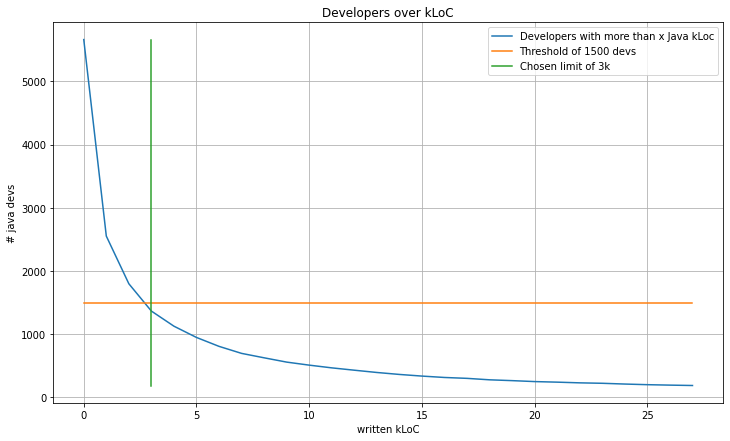

In [251]:
x = []
y = []
y2 = []
x2 = []
threshold = 1500
for i in range(28):
    result = dbUtils.runQuery('''
        SELECT COUNT(*) AS num
        FROM crm20.lb_languages
        WHERE language = 'java' AND loc >= '''+str(i * 1000)+'''
    ''', True)
    x.append(i)
    y.append(result['num'][0])
    y2.append(1500)
    x2.append(3)
    
pyplot.figure(figsize=(12, 7))
pyplot.grid()
pyplot.title('Developers over kLoC')
pyplot.xlabel('written kLoC')
pyplot.ylabel('# java devs')
pyplot.plot(x, y)
pyplot.plot(x, y2)
pyplot.plot(x2, y)
pyplot.legend(['Developers with more than x Java kLoc', 'Threshold of '+str(threshold)+' devs', 'Chosen limit of 3k'])
pyplot.savefig('javaDevPerLoc.png')

Old graph:

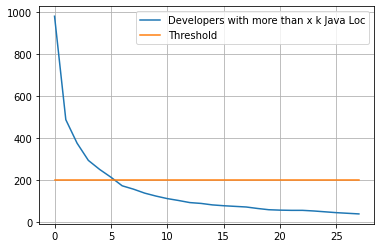

In [78]:
x = []
y = []
y2 = []
for i in range(28):
    result = dbUtils.runQuery('''
        SELECT COUNT(*) AS num
        FROM crm20.lb_languages
        WHERE language = 'java' AND loc >= '''+str(i * 1000)+'''
    ''', True)
    x.append(i)
    y.append(result['num'][0])
    y2.append(200)
    
pyplot.grid()
pyplot.plot(x, y)
pyplot.plot(x, y2)
pyplot.legend(['Developers with more than x k Java Loc', 'Threshold'])

In [139]:
javaUsers = dbUtils.runQuery('''
    DROP VIEW IF EXISTS crm20.lb_java_users;
    
    CREATE VIEW crm20.lb_java_users AS
        (SELECT *
        FROM crm20.lb_languages
        WHERE language = 'java' AND loc > 3000);
        
    SELECT * FROM crm20.lb_java_users
''')

Time used: 0.10370635986328125


In [140]:
display(javaUsers)

,author_id,language,loc,first_written
0,118,java,4458.0,2014-07-12 13:58:27
1,1361,java,52662.0,2014-08-23 09:58:05
2,4073,java,5481.0,2014-08-14 02:10:11
3,5768,java,191889.0,2010-08-04 18:11:50
4,10401,java,4762.0,2012-08-30 09:36:51
...,...,...,...,...
1361,49736842,java,3194.0,2019-03-01 08:29:23
1362,49975159,java,12942.0,2019-03-18 09:09:26
1363,50518011,java,11297.0,2019-04-09 18:20:00
1364,50573155,java,72624.0,2019-04-10 13:08:48


In [19]:
dbUtils.runQuery('''
    ALTER MATERIALIZED VIEW crm20.lb_polyglots
    RENAME TO lb_polyglots_view;
    ALTER MATERIALIZED VIEW crm20.lb_controlgroup
    RENAME TO lb_controlgroup_view;
    SELECT * FROM crm20.lb_polyglots_view
''')

Time used: 0.22378754615783691


,author_id,javaloc,javastart,secondary_languages,secloc,secstart
0,55149,48533.0,2012-08-18 19:14:30,[js],[13340],[2015-08-10 01:20:42]
1,61025,231507.0,2010-12-17 19:50:34,[js],[1494],[2013-10-09 16:20:00]
2,89727,90236.0,2012-03-01 13:56:58,[js],[32537],[2013-02-10 15:10:56]
3,100010,4449.0,2013-08-21 21:01:11,[js],[1214],[2014-05-16 19:11:29]
4,100236,143991.0,2010-04-11 12:32:30,[js],[42598],[2015-01-31 21:20:39]
...,...,...,...,...,...,...
103,41410889,11749.0,2018-04-02 00:46:50,[js],[1263],[2018-04-13 04:04:22]
104,45852806,4813.0,2018-10-23 03:57:45,[py],[1928],[2018-11-09 02:44:09]
105,45985807,69531.0,2018-10-23 08:41:21,[js],[29569],[2018-10-23 08:57:52]
106,46354752,12717.0,2018-10-08 22:59:11,[js],[2197],[2018-10-09 13:36:55]


# Select Experiment Users

In [20]:
dbUtils.runQuery('''
        DROP TABLE IF EXISTS crm20.lb_polyglots;
        CREATE TABLE crm20.lb_polyglots AS (
            SELECT lb_java_users.author_id, lb_java_users.loc AS javaLoC, lb_java_users.first_written as javaStart, ARRAY_AGG(lb_languages.language) AS secondary_languages, ARRAY_AGG(lb_languages.loc) AS secLoC, ARRAY_AGG(lb_languages.first_written) as secStart
            FROM crm20.lb_java_users, crm20.lb_languages
            WHERE lb_java_users.author_id = lb_languages.author_id 
            AND (lb_languages.language = 'py' OR lb_languages.language = 'js') AND lb_languages.loc > 1000
            GROUP BY lb_java_users.author_id, lb_java_users.loc, lb_java_users.first_written
            HAVING lb_java_users.loc / 2 > ALL(ARRAY_AGG(lb_languages.loc))
            AND lb_java_users.first_written < ALL(ARRAY_AGG(lb_languages.first_written))
        );
        SELECT * FROM crm20.lb_polyglots
''')

Time used: 1.497013807296753


,author_id,javaloc,javastart,secondary_languages,secloc,secstart
0,55149,48533.0,2012-08-18 19:14:30,[js],[13340],[2015-08-10 01:20:42]
1,61025,231507.0,2010-12-17 19:50:34,[js],[1494],[2013-10-09 16:20:00]
2,89727,90236.0,2012-03-01 13:56:58,[js],[32537],[2013-02-10 15:10:56]
3,100010,4449.0,2013-08-21 21:01:11,[js],[1214],[2014-05-16 19:11:29]
4,100236,143991.0,2010-04-11 12:32:30,[js],[42598],[2015-01-31 21:20:39]
...,...,...,...,...,...,...
103,41410889,11749.0,2018-04-02 00:46:50,[js],[1263],[2018-04-13 04:04:22]
104,45852806,4813.0,2018-10-23 03:57:45,[py],[1928],[2018-11-09 02:44:09]
105,45985807,69531.0,2018-10-23 08:41:21,[js],[29569],[2018-10-23 08:57:52]
106,46354752,12717.0,2018-10-08 22:59:11,[js],[2197],[2018-10-09 13:36:55]


In [22]:
dbUtils.runQuery('''
        DROP TABLE IF EXISTS crm20.lb_controlgroup;
        CREATE MATERIALIZED VIEW crm20.lb_controlgroup AS (
            SELECT lb_java_users.author_id, lb_java_users.loc AS javaLoC,  lb_java_users.first_written as javaStart
            FROM crm20.lb_java_users
            WHERE author_id NOT IN (SELECT author_id FROM crm20.lb_languages WHERE (language = 'py' OR language = 'js'))
            AND MOD(author_id, 4) = 3 
            AND loc > 5000
        );
        SELECT * FROM crm20.lb_controlgroup
''')

Time used: 0.34844303131103516


,author_id,javaloc,javastart
0,16503,106978.0,2010-09-30 11:48:03
1,34131,174060.0,2010-07-22 11:55:16
2,99671,20371.0,2012-07-14 12:27:07
3,153911,5064.0,2013-11-19 15:26:37
4,338779,13707.0,2012-07-09 07:15:19
...,...,...,...
101,46946759,10000.0,2019-05-10 07:02:55
102,49175119,16300.0,2019-02-03 02:28:33
103,49975159,12942.0,2019-03-18 09:09:26
104,50518011,11297.0,2019-04-09 18:20:00


In [162]:
polyglotProjects = dbUtils.runQuery('''
    CREATE VIEW crm20.lb_polyglotProjects AS (
        SELECT DISTINCT repo_id, url, name
        FROM lb_polyglots, ght.project_members, ght.projects
        WHERE author_id = user_id
        AND repo_id = id
    );
    SELECT * FROM  crm20.lb_polyglotProjects
''')
display(polyglotProjects)
controlgroupProjects = dbUtils.runQuery('''
    CREATE VIEW crm20.lb_controlgroupProjects AS (
        SELECT DISTINCT repo_id, url, name
        FROM lb_controlgroup, ght.project_members, ght.projects
        WHERE author_id = user_id
        AND repo_id = id
    );
    SELECT * FROM crm20.lb_controlgroupProjects
''')
display(controlgroupProjects)

Time used: 0.42659735679626465


,repo_id,url,name
0,1182,https://api.github.com/repos/twitter/scalding,scalding
1,1372,https://api.github.com/repos/twitter/finagle,finagle
2,3732,https://api.github.com/repos/ceylon/ceylon-ide...,ceylon-ide-eclipse
3,17827,https://api.github.com/repos/twitter/flockdb,flockdb
4,34552,https://api.github.com/repos/thiagoruis/dotNET...,dotNET-Grupo-2
...,...,...,...
989,131699833,https://api.github.com/repos/suimn416/2019.Spr...,2019.Spring.AI_BOSS
990,131979956,https://api.github.com/repos/capturetheworld/c...,cs151project
991,132564033,https://api.github.com/repos/idio/langdetect,langdetect
992,134135475,https://api.github.com/repos/luchizina/phpLuna,phpLuna


Time used: 0.35388851165771484


,repo_id,url,name
0,7589,https://api.github.com/repos/nxtbgthng/OAuth2C...,OAuth2Client
1,8612,https://api.github.com/repos/jboss-switchyard/...,components
2,17345,https://api.github.com/repos/jboss-switchyard/...,tools
3,23282,https://api.github.com/repos/cloudera/crunch,crunch
4,24828,https://api.github.com/repos/jboss-switchyard/...,quickstarts
...,...,...,...
378,128921855,https://api.github.com/repos/huangcs3/cloudtest,cloudtest
379,129200651,https://api.github.com/repos/wer345/vscodegit,vscodegit
380,129732012,https://api.github.com/repos/MatteoCultrera/Fo...,Foody_User
381,134529452,https://api.github.com/repos/mibaldi/Architect...,ArchitectCodersG3


In [253]:
dbUtils.runQuery('''
    CREATE VIEW crm20.lb_experimentusers AS (
        SELECT author_id
        FROM crm20.lb_polyglots 
        UNION
        SELECT author_id
        FROM crm20.lb_controlgroup
    );
    SELECT * FROM  crm20.lb_experimentusers
''')

Time used: 0.3082089424133301


,author_id
0,49975159
1,32388630
2,11128019
3,4648147
4,5683227
...,...
209,9678907
210,46257459
211,40932899
212,10133167


---
# Statistics about user languages:

### How many users write n times as much Java code as their secondary language (but still 1000 LoC in Secondary!)

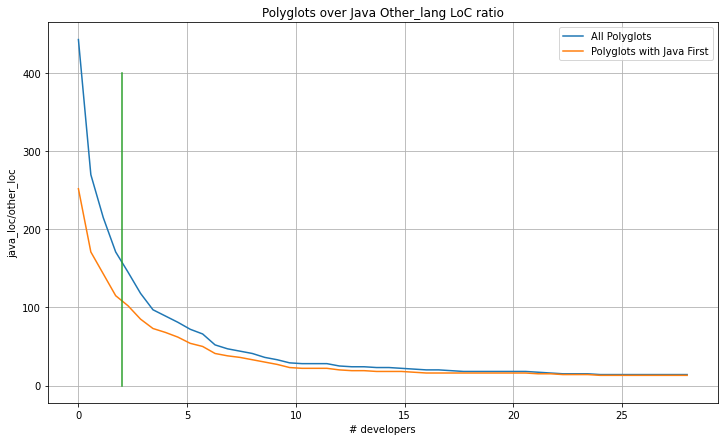

In [252]:
x = []
y = []

x2 = []
y2 = []
for i in numpy.linspace(0, 28, 50):
    result = dbUtils.runQuery('''
        SELECT '''+str(i)+''' AS factor, COUNT(author_id) AS devs FROM
            (SELECT lb_java_users.author_id, lb_java_users.loc AS javaLoC, ARRAY_AGG(lb_languages.language) AS secondary_languages, ARRAY_AGG(lb_languages.loc) AS secLoC
            FROM crm20.lb_java_users, crm20.lb_languages
            WHERE lb_java_users.author_id = lb_languages.author_id 
            AND (lb_languages.language = 'py' OR lb_languages.language = 'js') AND lb_languages.loc > 1000
            GROUP BY lb_java_users.author_id, lb_java_users.loc
            HAVING lb_java_users.loc >= ALL(ARRAY_AGG(lb_languages.loc * '''+str(i)+'''))) AS x
    ''', True)
    x.append(result['factor'][0])
    y.append(result['devs'][0])
    
for i in numpy.linspace(0, 28, 50):
    result = dbUtils.runQuery('''
        SELECT '''+str(i)+''' AS factor, COUNT(author_id) AS devs FROM
            (SELECT lb_java_users.author_id, lb_java_users.loc AS javaLoC, ARRAY_AGG(lb_languages.language) AS secondary_languages, ARRAY_AGG(lb_languages.loc) AS secLoC
            FROM crm20.lb_java_users, crm20.lb_languages
            WHERE lb_java_users.author_id = lb_languages.author_id 
            AND (lb_languages.language = 'py' OR lb_languages.language = 'js') AND lb_languages.loc > 1000
            GROUP BY lb_java_users.author_id, lb_java_users.loc, lb_java_users.first_written
            HAVING lb_java_users.loc >= ALL(ARRAY_AGG(lb_languages.loc * '''+str(i)+'''))
            AND lb_java_users.first_written < ALL(ARRAY_AGG(lb_languages.first_written))) AS x
    ''', True)
    x2.append(result['factor'][0])
    y2.append(result['devs'][0])
    
pyplot.figure(figsize=(12, 7))
pyplot.grid()
pyplot.title('Polyglots over Java Other_lang LoC ratio')
pyplot.xlabel('# developers')
pyplot.ylabel('java_loc/other_loc')
pyplot.plot(x, y)
pyplot.plot(x2, y2)
pyplot.plot([2,2], [0,400])
pyplot.legend(['All Polyglots', 'Polyglots with Java First'])
pyplot.savefig('polyglotsPerFactor.png')

### Which secondary languages are there?

In [143]:
dbUtils.runQuery('''
    SELECT secondary_languages, COUNT(author_id)
    FROM
        (SELECT lb_java_users.author_id, ARRAY_AGG(lb_languages.language) AS secondary_languages
        FROM crm20.lb_java_users, crm20.lb_languages
        WHERE lb_java_users.author_id = lb_languages.author_id 
        AND (lb_languages.language = 'py' OR lb_languages.language = 'js') AND lb_languages.loc > 1000
        GROUP BY lb_java_users.author_id) AS secondaries
    GROUP BY secondary_languages
''')

Time used: 0.08953547477722168


,secondary_languages,count
0,[js],362
1,"[js, py]",32
2,[py],43
3,"[py, js]",6


## Number of developers per language (or file ending, more precisely)
Note: As there is no filtering for linecount > 0, this numbery may differ from the other ones

In [144]:
dbUtils.runQuery('''
    SELECT language, COUNT(author_id) AS devs
    FROM crm20.lb_languages
    GROUP BY language
    HAVING 
        language <> 'png' 
        AND language <> 'md' 
        AND language <> 'None' 
        AND language <> 'txt' 
        AND language <> 'gitignore' 
        AND language <> 'html' 
        AND language <> 'css'
        AND language <> 'scss'
        AND language <> 'xml'
        AND language <> 'json'
        AND language <> 'jpg'
        AND language <> 'yml'
        AND language <> 'svg'
        AND language <> 'ttf'
        AND language <> 'properties'
        AND language <> 'gif'
        AND language <> 'ico'
        AND language <> 'lock'
        AND language <> 'pdf'
    ORDER BY devs DESC
    LIMIT 30
''')

Time used: 0.17014098167419434


,language,devs
0,js,8792
1,java,5660
2,py,4097
3,php,3014
4,h,2536
5,sh,2243
6,woff,2176
7,cs,2117
8,eot,2106
9,rb,1874
